<a href="https://colab.research.google.com/github/jpatra72/Advanced_ML/blob/main/GAN_Implementation_Based_on_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Build a GAN model and train the model with MNIST dataset
1. Update Discrimator network to maximize $\log(D(x)) + \log(1 - D(G(z)))$ and Generator network to minimize $\log(1 - D(G(z))$
2. Change the Generator network to maximize $\log(D(G(z))$ instead of minimizing $\log(1 - D(G(z))$

### Running notebooks on Google Colaboratory

* Goto [Google Colab](https://colab.research.google.com/)  
* Under `File` menu, click on `Upload notebook` and upload this notebook  
* To run the notebook with GPU, click on `Runtime` menu, select `Change runtime type`, and select `GPU` as Hardware accelerator  
  
Note:  
* If you see a `“RuntimeError: CUDA error: device-side assert triggered”` error, try running the notebook on CPU (by choosing `None` in Hardware accelerator as discussed above) to get a more detailed traceback for the error.  
* If the notebook is running fine with CPU and the same error persists while using GPU, try restarting the runtime.

# Generative Adverserial Networks

Import the installed packages

In [ ]:
import os
import random
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.datasets import CIFAR10, MNIST
from torchvision.utils import make_grid

from tqdm.notebook import tqdm

### Set random seed for reproducibility

In [ ]:
seed = 12
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
print("Random Seed: ", seed)

Random Seed:  12


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Create the input data transformations and dataloader

PyTorch has two primitives to work with data: `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`. `Dataset` stores the  data samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset.  
The `torchvision.datasets` module contains Dataset objects for many real-world vision data. We will use the MNIST dataset of handwritten digits in this exercise.  
Every TorchVision Dataset includes two arguments: `transform` and `target_transform` to modify the data samples and labels respectively. You can use `torchvision.transforms.Compose` to compose multiple transformations together.  
For our MNIST dataset, we can use the `torchvision.transforms.ToTensor` to convert the numpy array to a tensor, and `torchvision.transforms.Normalize` for normalizing the input to the range $\left[-1, 1\right]$.

In [ ]:
# Size of the generated images (28x28).
image_size = 28

# Creating the transformations
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5), (0.5))]
)

# Define the train and test sets from MNIST data
dataset = MNIST("./data", transform=transform, download=True)

### Define the dataloaders

Here we define a batch size for the dataloader, i.e. each element in the dataloader iterable will return a batch of features and labels. Additionally, we can shuffle the data in each epoch.

In [ ]:
# Setting the batch size
batch_size = 32

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Plot example dataset

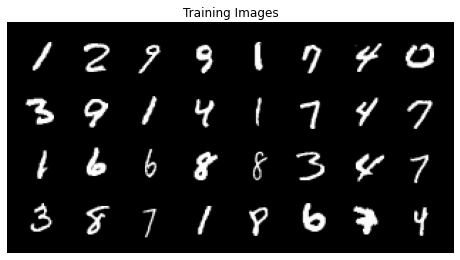

In [ ]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        make_grid(
            real_batch[0].to(device)[:batch_size], padding=10, normalize=True
        ).cpu(),
        (1, 2, 0),
    )
)

### Initialize the parameters of the model

Define a function to initialize the paramters of the model as suggested in the [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf).  


In [ ]:
mean = 0.0
std = 0.02


def weights_init(model):
    classname = model.__class__.__name__
    if classname.find("Conv") != -1:
        model.weight.data.normal_(mean, std)
    elif classname.find("BatchNorm") != -1:
        model.weight.data.normal_(mean, std)
        model.bias.data.fill_(0)

### Define the generator class

Define a generator class with the following number of output feature maps in the hidden layers:  
$\left[128, 64, 32\right]$  

Please refer [transposed convolution layer](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html),  [batch normalization layer](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html), and [activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) for defining the network.  

The class is to be inherited from the base [Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) from PyTorch.

In [ ]:
# Defne some hyperparameters
num_latent_features = 10

# Defining the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(num_latent_features, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 3, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z):
        output = self.main(z)
        return output

Instantiate the generator model and initialize the parameters

In [ ]:
# Creating the generator
netG = Generator().to(device)
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(10, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


### Define the discriminator class

Define a discriminator class with the following number of output feature maps in the hidden layers:  
$\left[32, 64, 128\right]$  

Please refer [convolution layer](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity), and [batch normalization layer](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) for defining the network.  

The class is to be inherited from the base [Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) from PyTorch.

In [ ]:
# Defining the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, data):
        output = self.main(data)
        return output.view(-1)

Instantiate the generator model and initialize the parameters

In [ ]:
# Creating the discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


### Define the loss function and optimizers

Discrimator network is trained to maximize $\log(D(x)) + \log(1 - D(G(z)))$ and Generator network to minimize $\log(1 - D(G(z))$  

Binary cross entropy loss has both the terms we need to optimize for GAN.  

$BCE_{n}=-\left[y_{n} \cdot \log x_{n}+\left(1-y_{n}\right) \cdot \log \left(1-x_{n}\right)\right]$  

We need to choose the labels correctly while training to use the needed term from the loss function.  

Also initialize optimizers for both discriminator and generator

In [ ]:
criterion = nn.BCELoss()
learning_rate = 0.0002
beta_1 = 0.5
beta_2 = 0.999
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta_1, beta_2))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta_1, beta_2))

### Define the labels

We define the labels for real and fake samples.  
Also a constant noise is defined which will help us in visualizing the training progress of generator.

In [ ]:
# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(batch_size, num_latent_features, 1, 1, device=device)
real_label = 1
fake_label = 0

A helper function to remove the normalization we added to the dataloader.  
This is useful while plotting the images which require the values to be in the range $\left[0, 1\right]$

In [ ]:
def scale(data, mean=0.5, std=0.5):
    data = mean + std * data
    return data

### Train the model

Train the discriminator to maximize $\log(D(x)) + \log(1 - D(G(z)))$ and Generator network to minimize $\log(1 - D(G(z))$.   

**Perform the following steps while training discriminator:**  
* Iterate over batches of input data in each epoch
* PyTorch accumulates the parameter gradients on each subsequent backward pass, thus we need to set the gradients explicitly to zero in each iteration to avoid this. This can be done by calling function `zero_grad()` on the network
* Perform a forward pass in the discriminator with the input batch (ie., real images)
* Define the labels for the input. Note that we only have two labels (ie., real and fake). `torch.full()` fills a tensor with a given value
* Calculate the loss for this batch of input (ie., maximize $\log(D(x)$)
* Calculate the gradients for the model parameters in the direction of minimizing the loss. The `backward()` function is used on the loss to calculate this gradients
* Perform a forward pass in the discriminator with the fake batch of images generated by the generator. `torch.randn()` can be used to generate random tensors. `detach()` function can be used on a tensor so that gradients are not backpropogated through this variable. This is needed as we dont need to calculate gradients for generator parameters while training discriminator 
* Calculate the loss for this fake batch of input (ie., maximize $\log(1 - D(G(z))$)
* Calculate the gradients and perform the optimization of discriminator parameters using the gradients. The `step()` function is used on the optimizer to update the parameters   

**Perform the following steps while training generator:**  
* Perform a forward pass in the discriminator with the fake batch of images generated by the generator
* Calculate the generator's loss (ie., minimize $\log(1 - D(G(z)))$), gradients for the generator parameters and optimize


  0%|          | 0/1875 [00:00<?, ?batch/s]

  0%|          | 0/1875 [00:00<?, ?batch/s]

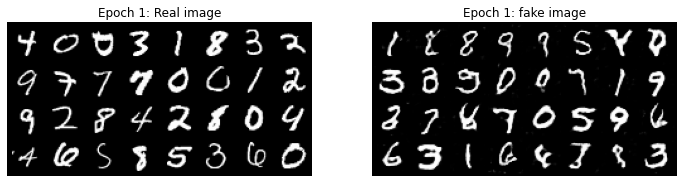

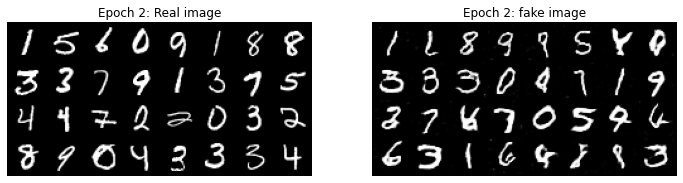

In [ ]:
epochs = 2

# Lists to keep track of progress
G_losses = []
D_losses = []

for epoch in range(1, epochs + 1):
    with tqdm(dataloader, unit="batch") as epoch_pbar:
        for data in epoch_pbar:
            epoch_pbar.set_description(f"Epoch {epoch}")
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            # train with real
            netD.zero_grad()
            real_img, _ = data
            real_img = real_img.to(device)
            label = torch.full(
                (batch_size,), real_label, dtype=real_img.dtype, device=device
            )

            output = netD(real_img)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            # train with fake
            noise = torch.randn(batch_size, num_latent_features, 1, 1, device=device)
            fake_img = netG(noise)
            label.fill_(fake_label)
            output = netD(fake_img.detach())
            errD_fake = criterion(output, label)
            errD_fake.backward()

            errD = errD_real + errD_fake
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            # fill with real labels to use the log(x) term of bce loss
            label.fill_(real_label)
            output = netD(fake_img)
            errG = criterion(output, label)
            errG.backward()
            optimizerG.step()

            od = OrderedDict()
            od["Dis_loss"] = errD.item()
            od["Gen_loss"] = errG.item()
            epoch_pbar.set_postfix(od)
            
            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

        f, axarr = plt.subplots(1, 2, figsize=(12, 12))
        norm = plt.Normalize(0, 255)
        real_img = real_img.detach().cpu()
        real_img = scale(real_img)
        image_grid = make_grid(real_img.view(batch_size, 1, 28, 28), nrow=8).permute(
            1, 2, 0
        )
        axarr[0].imshow(image_grid.numpy(), cmap="gray", norm=norm)
        axarr[0].axis("off")
        axarr[0].set_title(f"Epoch {epoch}: Real image")

        fake_img = netG(fixed_noise)
        fake_img = fake_img.detach().cpu()
        fake_img = scale(fake_img)
        image_grid = make_grid(fake_img.view(batch_size, 1, 28, 28), nrow=8).permute(
            1, 2, 0
        )
        axarr[1].imshow(image_grid.numpy(), cmap="gray", norm=norm)
        axarr[1].axis("off")
        axarr[1].set_title(f"Epoch {epoch}: fake image")
        f.show()

        

### Plot the training loss

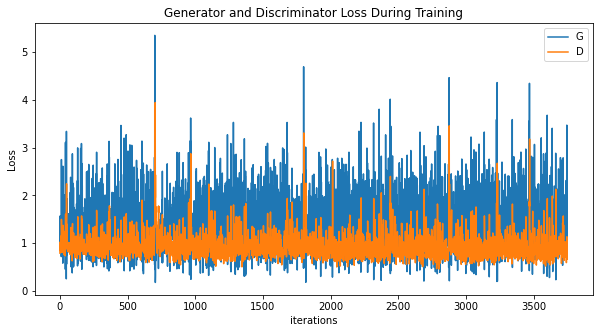

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()